# Canny and OTSU prototyping <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `DEA Sandbox` and `NCI` environments
* **Products used:** 
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)

## Background
Remote sensing indices are combinations of spectral bands used to highlight features in the data and the underlying landscape.
Using Digital Earth Australia's archive of analysis-ready satellite data, we can easily calculate a wide range of remote sensing indices that can be used to assist in mapping and monitoring features like vegetation and water consistently through time, or as inputs to machine learning or classification algorithms.


## Description
This notebook demonstrates how to:
 
* Calculate an index manually using `xarray`
* Calculate one or multiple indices using the function `calculate_indices` from `dea_bandindices.py`
 
***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import sys
import xarray as xr

sys.path.append("../Scripts")
from dea_datahandling import load_ard
from dea_plotting import rgb
from dea_bandindices import calculate_indices
from dea_spatialtools import interpolate_2d, subpixel_contours
from dea_dask import create_local_dask_cluster
from dea_datahandling import mostcommon_crs

# Create local dask cluster to improve data load time
create_local_dask_cluster()


Client Scheduler: tcp://127.0.0.1:40511 Dashboard: /user/robbibt/proxy/8787/status,Cluster Workers: 1 Cores: 8 Memory: 61.42 GB


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='Calculating_band_indices')

## Create a query and load satellite data
To demonstrate how to compute a remote sensing index, we first need to load in a time series of satellite data for an area. 
We will use data from the Landsat 8 satellite:

In [31]:
# # Roebuck
# xmin, ymax = (122.254719, -18.155366)
# xmax, ymin = (122.135270, -18.266834)

# # Pilbara
# xmin, ymax = (117.42, -20.57)
# xmax, ymin = (117.85, -20.77)

# # Perth
# ymax, xmin = -31.578676, 115.595223
# ymin, xmax = -32.307006, 115.861641

# # Adelaide
# ymax, xmin = -34.758109, 138.376060
# ymin, xmax = -35.189096, 138.543601

# # NT Gulf
# xmin, ymax = 135.80364970, -13.06364945
# xmax, ymin = 136.15279294, -13.79379692

# NT Stuart Point
xmin, ymax = 130.962280, -11.964239
xmax, ymin = 132.531951,  -12.395141

# Tassie
ymax, xmin = -40.96694, 145.71751
ymin, xmax = -41.10005, 146.02478

# # Gold Coast
# xmin, ymax = 153.35306815, -27.69805073
# xmax, ymin = 153.62040169, -28.29843108

# # Sydney
# ymax, xmin = -33.825292, 151.192090
# ymin, xmax = -34.014403, 151.309498


# Query params
query = {'x': (xmin, xmax), 
         'y': (ymin, ymax), 
         'time': ('2017', '2019')}

# Determine the most common CRS for the query
native_crs = mostcommon_crs(dc, product='ga_ls8c_ard_3', query=query)
print(native_crs)

# Load params
load_query = {
    'measurements': ['nbart_blue', 'nbart_green', 'nbart_red', 
                     'nbart_nir', 'nbart_swir_1', 'nbart_swir_2', 'fmask'],
    'output_crs': native_crs,
    'dask_chunks': {'x': 3000, 'y': 3000, 'time': 1},
    'resampling': {'*': 'cubic', 'fmask': 'nearest', 'oa_fmask': 'nearest'},
    'resolution': (-30, 30),
    'align': (15, 15),
    'group_by': 'solar_day'
}

# Load available data from Landsat 8 and filter to retain only times
# with at least 99% good data
ds = load_ard(dc=dc,
              products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],
#               min_gooddata=0.70,
              mask_pixel_quality=False,
              **query,
              **load_query)


epsg:32655
Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Returning 245 time steps as a dask array


Setting tide modelling location from dataset centroid: 145.87, -41.03


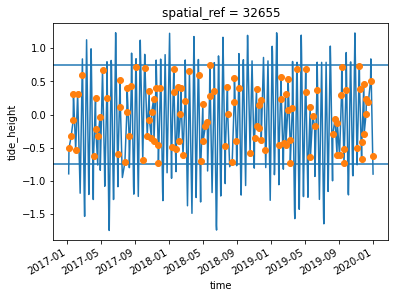

In [32]:
from dea_coastaltools import tidal_tag

# Model tide heights
ds_tidal = tidal_tag(ds)

# Identify range
tide_min, tide_max = ds.tide_height.quantile([0, 1]).values
tide_range = (tide_max - tide_min) * 0.25
ds.tide_height.plot()
plt.gca().axhline(0 - tide_range)
plt.gca().axhline(0 + tide_range)

# Keep subset
to_keep = (ds.tide_height > (0 - tide_range)) & (ds.tide_height < (0 + tide_range))
ds = ds.sel(time=to_keep).load()
ds.tide_height.plot(ax=plt.gca(), marker='o', linestyle='')


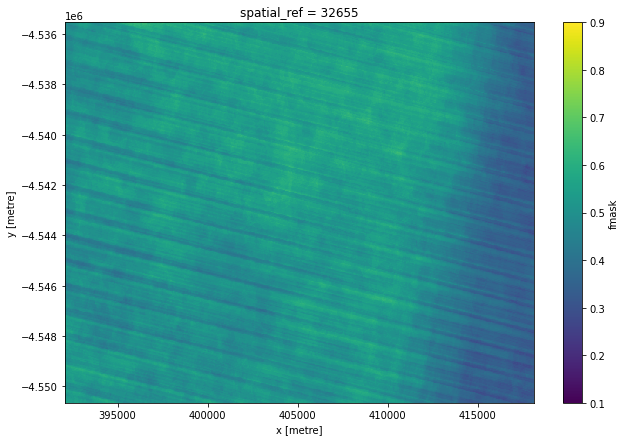

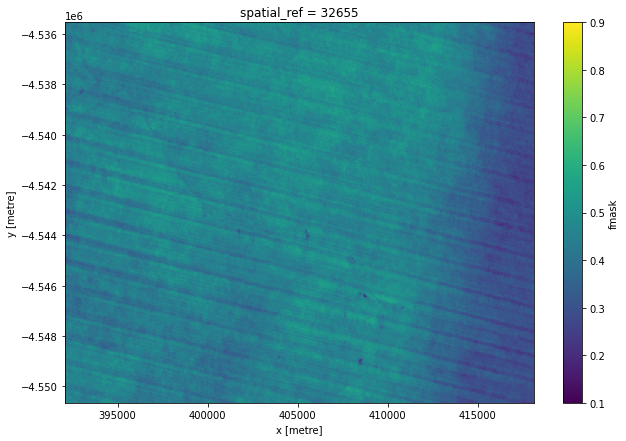

In [33]:
from skimage.morphology import binary_erosion, binary_dilation, binary_closing, disk

def cloud_buffer(da, dilate_radius=10, erode_radius=10):

    # First remove small or narrow features using morphological closing
    mask_dilated = binary_dilation(da, disk(dilate_radius))
    
    # Then buffer remaining pixels by a radius to mask cloud edges
    mask_eroded = binary_erosion(mask_dilated, disk(erode_radius))
    
    return mask_eroded

nodata = ds.fmask == 0
cloud_shadow = ~ds.fmask.isin([2, 3])
new_mask = cloud_shadow.groupby('time').apply(cloud_buffer).where(~nodata, 0)

# Plot
new_mask.mean(dim='time').plot(size=7, vmin=0.1, vmax=0.9)
cloud_shadow.where(~nodata, 0).mean(dim='time').plot(size=7, vmin=0.1, vmax=0.9)

In [34]:
# new_mask = cloud_shadow.where(~nodata, 0)
ds = ds.where(new_mask).where(ds != -999)

### Plot the first image to see what our area looks like
We can use the `rgb` function to plot the first timestep in our dataset as a true colour RGB image:

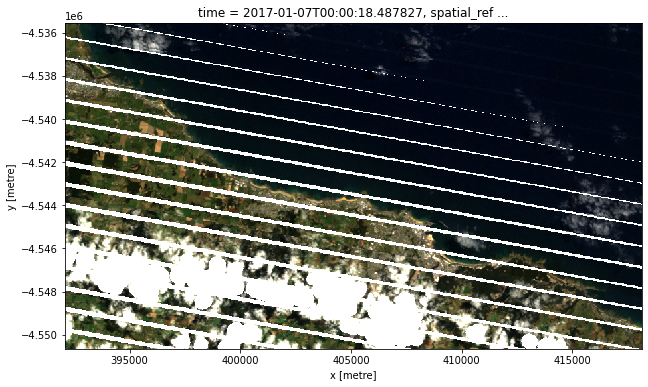

In [35]:
# Plot as an RGB image
index = 0
rgb(ds, index=index)


In [36]:
# write_cog(geo_im=ds[['nbart_swir_2', 'nbart_nir', 'nbart_green']].isel(time=2).to_array(),
#           fname='test_rgb.tif',
#           overwrite=True)

### Using `calculate_indices`

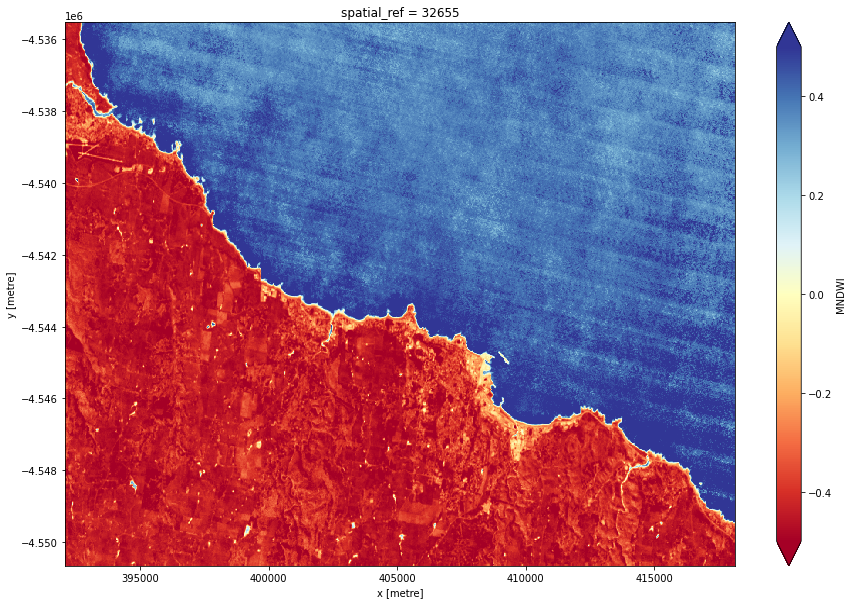

In [37]:
# Calculate MNDWI using `calculate indices`
ds = calculate_indices(ds, index='MNDWI', collection='ga_ls_3')

# Plot the results 
da = ds.MNDWI.median(dim='time')
da.plot(vmin=-0.5, vmax=0.5, cmap='RdYlBu', size=10)


> **Note**: when using the `calculate_indices` function, it is important to set the `collection` parameter correctly. 
This is because different satellite collections use different names for the same bands, which can lead to invalid results if not accounted for. 
For Landsat (i.e. GA Landsat Collection 3), specify `collection='ga_ls_3'`. 
For Sentinel 2 (i.e. GA Sentinel 2 Collection 1), specify `collection='ga_s2_1'`.

### Using calculate_indices to calculate multiple indices at once
The `calculate_indices` function makes it straightforward to calculate multiple remote sensing indices in one line of code.

In the example below, we will calculate `NDVI` as well as two common water indices: the Normalised Difference Water Index (`NDWI`), and the Modified Normalised Difference Index (`MNDWI`).
The new indices will appear in the list of `data_variables` below:

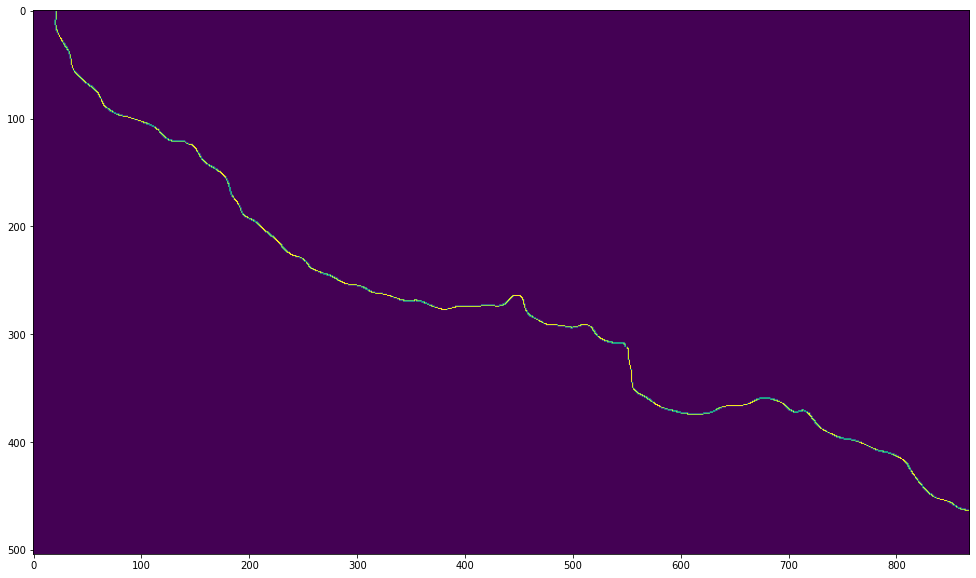

In [38]:
from skimage.morphology import binary_erosion, binary_dilation, binary_closing, disk
from skimage import feature, filters, measure

# da = ds.MNDWI.isel(time=index)
mndwi = da.values

# dry_buffered = binary_erosion(mndwi > -0.5, disk(10))
# mndwi = np.where(mndwi > -0.5, mndwi, -0.5)
mndwi_smoothed = filters.gaussian(mndwi, sigma=2)

edges = feature.canny(mndwi_smoothed, sigma=5, low_threshold=0.25)

edges_labelled = measure.label(edges)
edges_info = measure.regionprops(edges_labelled)
large_edges = [i.label for i in edges_info if i.area > 100]
edges_out = np.isin(edges_labelled, large_edges)
fig = plt.figure(figsize=(20, 10))
plt.imshow(edges_out)


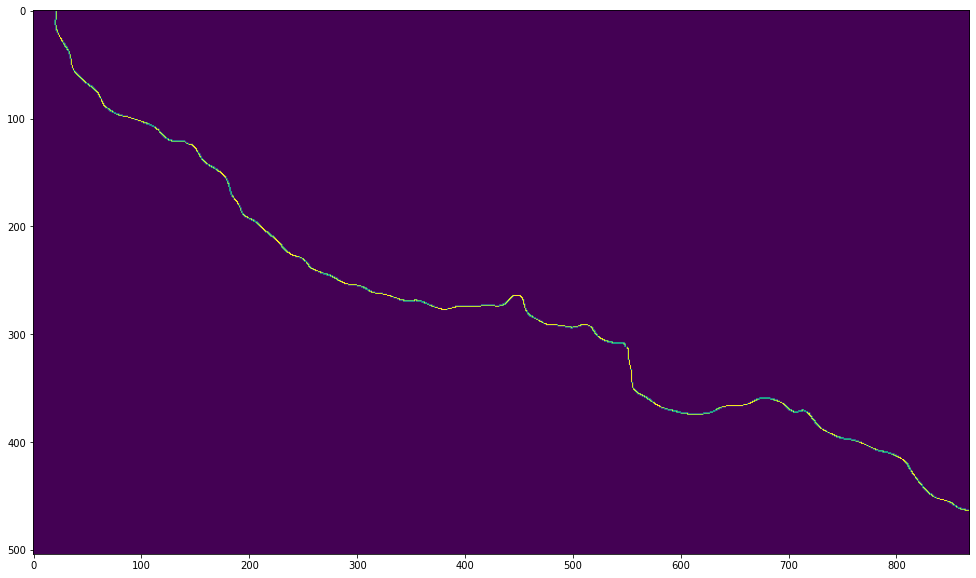

In [39]:
nobs_ds = (~ds.MNDWI.isnull()).sum(dim=['time']) >= 5
fig = plt.figure(figsize=(20, 10))
edges_out = np.where(nobs_ds, edges_out, False)
plt.imshow(edges_out)

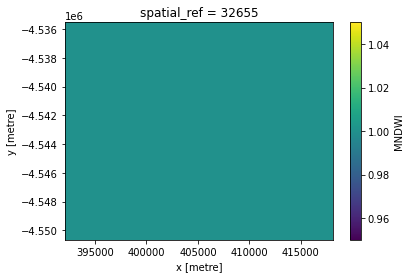

In [40]:
((~ds.MNDWI.isnull()).sum(dim=['time']) >= 5).plot()

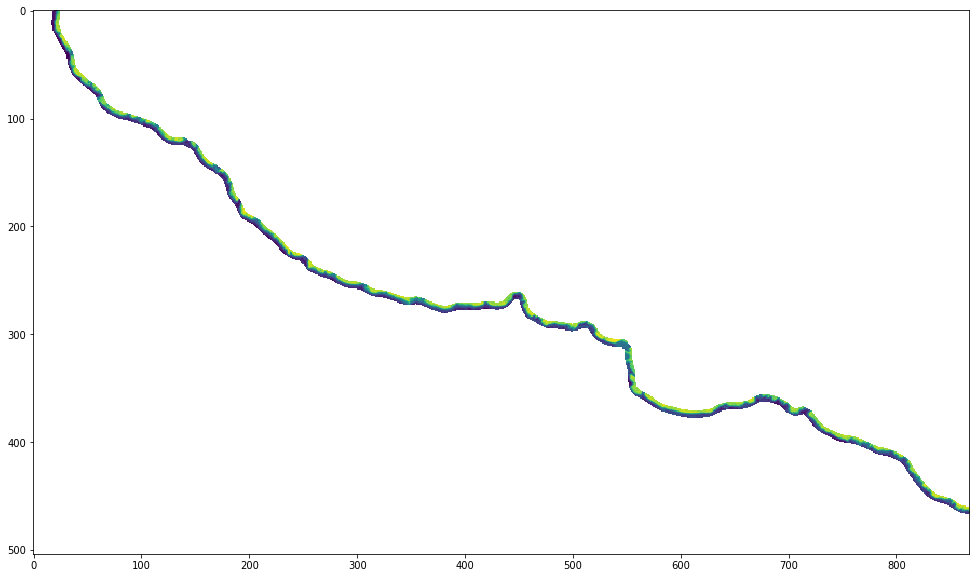

In [41]:
local_window = 3
edge_buffered = binary_dilation(edges_out, disk(local_window))
mndwi_masked = np.where(edge_buffered, mndwi, np.nan)
fig = plt.figure(figsize=(20, 10))
plt.imshow(mndwi_masked, interpolation='nearest')

(array([   0.,    0.,  368., 2160., 1200.,  724.,  689., 1823.,  422.,
           0.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

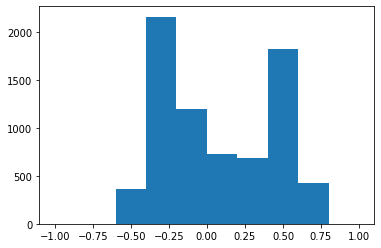

In [42]:
plt.hist(mndwi_masked[np.isfinite(mndwi_masked)], range=(-1, 1.0))

/env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


0.14147222142613852


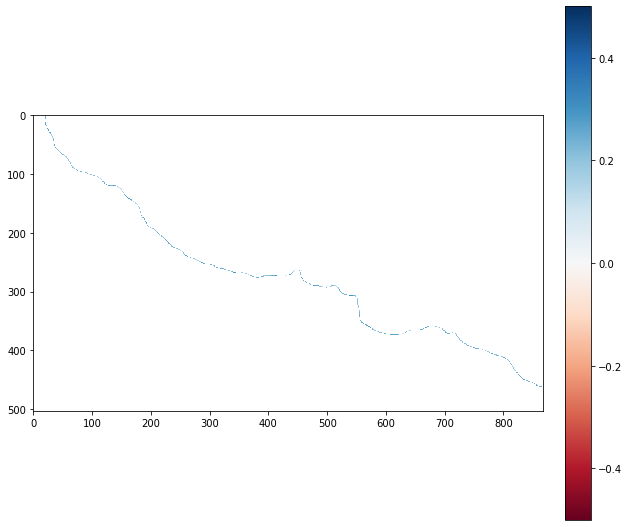

In [43]:
selem = disk(5)

from skimage.filters import threshold_otsu, rank

# local_otsu = rank.otsu(mndwi_masked, selem)
local_otsu = rank.otsu(mndwi_masked, disk(local_window * 2)) / 255.0
# local_otsu = filters.gaussian(local_otsu, sigma=1)
local_otsu[~edges_out] = np.nan
threshold_global_otsu = threshold_otsu(mndwi_masked[edges_out])
global_otsu = mndwi_masked[np.isfinite(mndwi_masked)] >= threshold_global_otsu

print(threshold_global_otsu)
fig = plt.figure(figsize=(10, 20))
plt.imshow(local_otsu, vmin=-0.5, vmax=0.5, cmap='RdBu', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)

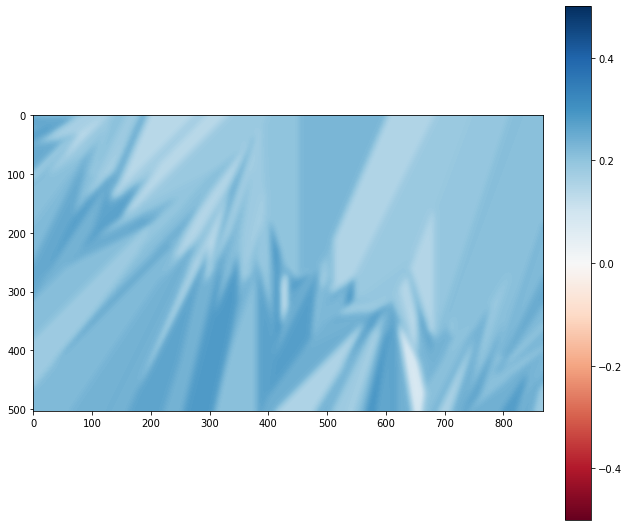

In [44]:
import scipy.interpolate

y_coords, x_coords = np.nonzero(np.isfinite(local_otsu))
points_xy = np.vstack([x_coords, y_coords]).T
z_coords = local_otsu[np.isfinite(local_otsu)]
grid_y, grid_x = np.meshgrid(range(mndwi.shape[1]), range(mndwi.shape[0]))

local_otsu_interp = scipy.interpolate.griddata(points=points_xy, 
                           values=z_coords, 
                           method='nearest',
                           xi=(grid_y, grid_x))

local_otsu_out = filters.gaussian(local_otsu_interp, sigma=5)
fig = plt.figure(figsize=(10, 10))
plt.imshow(local_otsu_out)
plt.imshow(local_otsu_out, vmin=-0.5, vmax=0.5, cmap='RdBu')
plt.colorbar(fraction=0.046, pad=0.04)



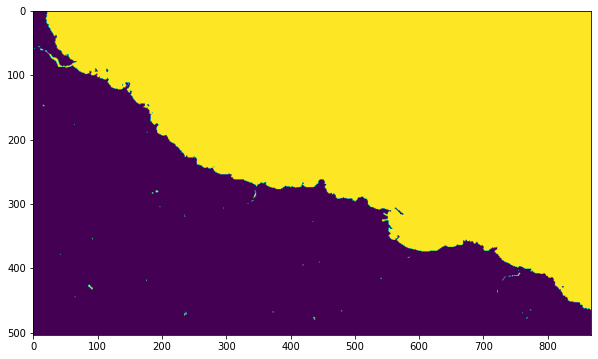

In [45]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(np.where(np.isfinite(mndwi), mndwi > threshold_global_otsu, np.nan))

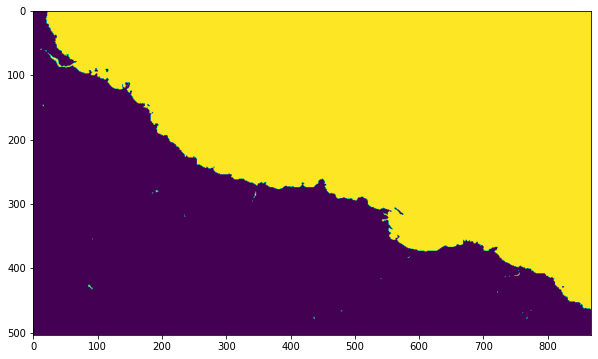

In [46]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(mndwi > local_otsu_out)


In [47]:
otsu_da = xr.DataArray(local_otsu_out, coords=da.coords, dims=da.dims, attrs=ds.attrs)
otsu_da

<xarray.DataArray (y: 504, x: 868)>
array([[0.2254988 , 0.22528628, 0.22504559, ..., 0.20784314, 0.20784314,
        0.20784314],
       [0.22887707, 0.22863927, 0.22836934, ..., 0.20784314, 0.20784314,
        0.20784314],
       [0.23249606, 0.23224023, 0.23194915, ..., 0.20784314, 0.20784314,
        0.20784314],
       ...,
       [0.21960784, 0.21960784, 0.21960784, ..., 0.18065641, 0.18053783,
        0.18046942],
       [0.21960784, 0.21960784, 0.21960784, ..., 0.18062505, 0.18051933,
        0.18045891],
       [0.21960784, 0.21960784, 0.21960784, ..., 0.18059866, 0.18050386,
        0.18045019]])
Coordinates:
  * y            (y) float64 -4.536e+06 -4.536e+06 ... -4.551e+06 -4.551e+06
  * x            (x) float64 3.921e+05 3.921e+05 ... 4.181e+05 4.181e+05
    spatial_ref  int32 32655
Attributes:
    crs:           epsg:32655
    grid_mapping:  spatial_ref

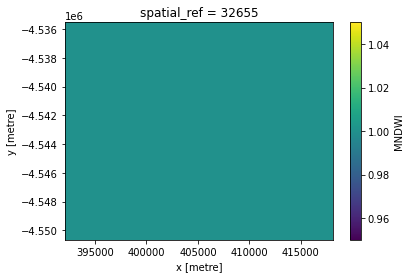

In [48]:
nobs_ds.plot()

In [49]:
da.load()
subpixel_contours(da=(da - otsu_da), z_values=0, crs=ds.crs, output_path='coastline_local_otsu.geojson', min_vertices=20)
subpixel_contours(da=da, z_values=threshold_global_otsu, crs=ds.crs, output_path='coastline_global_otsu.geojson', min_vertices=20)
subpixel_contours(da=da, z_values=0, crs=ds.crs, output_path='coastline_zero.geojson', min_vertices=20)

Operating in multiple z-value, single array mode
Writing contours to coastline_local_otsu.geojson
Operating in multiple z-value, single array mode
Writing contours to coastline_global_otsu.geojson
Operating in multiple z-value, single array mode
Writing contours to coastline_zero.geojson


/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,z_value,geometry
0,0,"MULTILINESTRING ((418110.000 -4549483.800, 418..."


In [30]:
from datacube.utils.cog import write_cog

write_cog(geo_im=(da - otsu_da),
          fname='example_subtracted.tif',
          overwrite=True)

write_cog(geo_im=otsu_da,
          fname='example_localotsu.tif',
          overwrite=True)

write_cog(geo_im=da,
          fname='example_mndwi.tif',
          overwrite=True)

write_cog(geo_im=ds[['nbart_blue', 'nbart_green', 'nbart_red']].median(dim='time').to_array().compute(),
          fname='example_true.tif',
          overwrite=True)

write_cog(geo_im=ds[['nbart_swir_2', 'nbart_nir', 'nbart_green']].median(dim='time').to_array().compute(),
          fname='example_false.tif',
          overwrite=True)

PosixPath('example_false.tif')

In [86]:
write_cog(geo_im=(~ds.MNDWI.isnull()).sum(dim=['time']).astype(np.int16),
          fname='example_count.tif',
          overwrite=True)

PosixPath('example_count.tif')

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** December 2019

**Compatible datacube version:**

In [23]:
print(datacube.__version__)

1.8.3


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)